In [1]:
# add path to sispeuede to sys.path in python and turn off warnings
import os, os.path
import pathlib
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import utils.common_data_needs as cdn

warnings.filterwarnings("ignore")

##  I'M LAZY, SO I HAVEN'T INSTALLED 

path_git = pathlib.Path("/Users/fabianfuentes/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    #"sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))
        

path_sisepuede_inputs_database = pathlib.Path("/Users/fabianfuentes/git/sisepuede_inputs.sqlite")              # e.g., "/Users/usuario/git/sisepuede_data_pipeline/sisepuede_inputs.sqlite"

import lib.sisepuede_data_constructs as dc             # from sisepuede_data_pipeline

construct = dc.SISEPUEDEDataConstructs(path_output_database = path_sisepuede_inputs_database, )


/Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/utilities/_toolbox.py:533: UserWarning: Path '/Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-08-05T22;41;52.104087' not found. It will not be created.
  warnings.warn(msg)
/Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/core/model_attributes.py:6824: UserWarning: 

                        MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution 
                        implemeted in ModelAttributes.get_variable_to_simplex

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   1117.8 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
/Users/fabianfuentes/anaconda3/envs/ssp_uganda_env/lib/python3.11/site-packages/sisepuede/utilities/_toolbox.py:2575: UserWarning: Warning passed from optional_log: Successfully initialized JuMP optimizer from solver module HiGHS..
  warnings.warn(f"Warning passed from optional_log: {msg}.")


In [2]:
dir_cur = pathlib.Path(os.getcwd())
input_data = dir_cur.joinpath("input_data")
output_data = dir_cur.joinpath("output_data")

In [3]:
# pull some SISEPUEDE elements
dict_ssp = cdn._setup_sisepuede_elements()

matt = dict_ssp.get("model_attributes", )
models = dict_ssp.get("models", )
regions = dict_ssp.get("regions", )
time_periods = dict_ssp.get("time_periods", )

# Statistical Abstract 2023

This part calculates the annual average cost of fuels (oil, kerosene, and diesel) in Uganda using official price data and exchange rates. The process involves:

1. **Data Preparation**: Annual average prices for each fuel (in UGX/Litre) are collected for recent years.
2. **Unit Conversion**: Prices are converted from UGX/Litre to UGX/m³ by multiplying by 1000.
3. **Currency Conversion**: UGX/m³ values are converted to USD/m³ using the official exchange rate for each year.
4. **Interpolation**: For years without direct price data, the last known UGX/Litre value is used and converted using the corresponding annual exchange rate. Missing years are filled using linear interpolation to create a continuous time series from 2015 to 2100.
5. **Result**: The final dataset provides annual fuel costs in USD/m³ for oil, kerosene, and diesel, suitable for further analysis or modeling.

In [4]:
# Annual average data (Average-23 and Average-22) in statistical abstract 2023
data = {
    "year": ["2022", "2023"],
    "Petrol_UGX_Litre": [5756.8, 5218.3],
    "Kerosene_UGX_Litre": [4135.0, 3629.2],
    "Diesel_UGX_Litre": [5493.7, 5099.7]
}

df = pd.DataFrame(data)

# Conversion to USD/m³ using year-specific exchange rates
exchange_rates_years = {2022: 3775, 
                        2023: 3668}

for idx, row in df.iterrows():
    year = int(row["year"])
    if year not in exchange_rates_years:
        raise ValueError(f"Exchange rate for year {year} not found.")
    rate = exchange_rates_years[year]
    for fuel in ["Petrol", "Kerosene", "Diesel"]:
        col_ugx_litre = f"{fuel}_UGX_Litre"
        col_usd_m3 = f"{fuel}_USD_m3"
        df.at[idx, f"{fuel}_UGX_m3"] = row[col_ugx_litre] * 1000
        df.at[idx, col_usd_m3] = df.at[idx, f"{fuel}_UGX_m3"] / rate

result = df[["year", "Petrol_USD_m3", "Kerosene_USD_m3", "Diesel_USD_m3"]]
result.head()


,year,Petrol_USD_m3,Kerosene_USD_m3,Diesel_USD_m3
0,2022,1524.980132,1095.364238,1455.284768
1,2023,1422.655398,989.422028,1390.321701


This code assumes that the real price in UGX/m³ for 2022 remains constant over time.

It uses the exchange rate for each year to convert this constant UGX/m³ price into a projected USD/m³ value.

The result is a historical and future time series of fuel prices in USD/m³ that is consistent with macroeconomic exchange rate trends.

In [5]:
# Exchange rates per year 
exchange_rates = {
    2015: 3240,
    2016: 3380,
    2017: 3600,
    2018: 3650,
    2019: 3695,
    2020: 3691,
    2021: 3542,
    2022: 3775,
    2023: 3668,  # base
    2024: 3679,
    2025: 3655
}

# Calculate price in UGX/m3 for 2023 (you can use the average or each year)
precios_ugx_m3 = {
    "Petrol": df.loc[df.year == "2023", "Petrol_USD_m3"].iloc[0] * exchange_rates[2023],
    "Kerosene": df.loc[df.year == "2023", "Kerosene_USD_m3"].iloc[0] * exchange_rates[2023],
    "Diesel": df.loc[df.year == "2023", "Diesel_USD_m3"].iloc[0] * exchange_rates[2023],
}

# Project to all years
result = []
for year, exch in exchange_rates.items():
    row = {"year": year}
    for fuel in ["Petrol", "Kerosene", "Diesel"]:
        # Price in USD/m3 for each year adjusted by exchange rate
        row[f"{fuel}_USD_m3"] = precios_ugx_m3[fuel] / exch
    result.append(row)

df_result = pd.DataFrame(result)
df_result.head(15)


,year,Petrol_USD_m3,Kerosene_USD_m3,Diesel_USD_m3
0,2015,1610.586420,1120.123457,1573.981481
1,2016,1543.875740,1073.727811,1508.786982
2,2017,1449.527778,1008.111111,1416.583333
3,2018,1429.671233,994.301370,1397.178082
4,2019,1412.259811,982.192152,1380.162382
5,2020,1413.790301,983.256570,1381.658087
6,2021,1473.263693,1024.618859,1439.779785
7,2022,1382.331126,961.377483,1350.913907
8,2023,1422.655398,989.422028,1390.321701
9,2024,1418.401740,986.463713,1386.164719


In [6]:
cost_enfu_fuel_gasoline_usd_per_m3 = df_result["Petrol_USD_m3"]
cost_enfu_fuel_kerosene_usd_per_m3 = df_result["Kerosene_USD_m3"]
cost_enfu_fuel_diesel_usd_per_m3 = df_result["Diesel_USD_m3"]

df_fuels = pd.DataFrame({
    "year": df_result["year"],
    "cost_enfu_fuel_gasoline_usd_per_m3": cost_enfu_fuel_gasoline_usd_per_m3,
    "cost_enfu_fuel_kerosene_usd_per_m3": cost_enfu_fuel_kerosene_usd_per_m3,
    "cost_enfu_fuel_diesel_usd_per_m3": cost_enfu_fuel_diesel_usd_per_m3
})

df_fuels

,year,cost_enfu_fuel_gasoline_usd_per_m3,cost_enfu_fuel_kerosene_usd_per_m3,cost_enfu_fuel_diesel_usd_per_m3
0,2015,1610.586420,1120.123457,1573.981481
1,2016,1543.875740,1073.727811,1508.786982
2,2017,1449.527778,1008.111111,1416.583333
3,2018,1429.671233,994.301370,1397.178082
4,2019,1412.259811,982.192152,1380.162382
5,2020,1413.790301,983.256570,1381.658087
6,2021,1473.263693,1024.618859,1439.779785
7,2022,1382.331126,961.377483,1350.913907
8,2023,1422.655398,989.422028,1390.321701
9,2024,1418.401740,986.463713,1386.164719


## World Energy Outlook 2024

We use the price projections from the IEA World Energy Outlook (WEO) to extend and calibrate our base fuel price scenarios. The WEO provides authoritative long-term forecasts for global energy prices, which we apply to project Uganda’s fuel costs through 2100. This approach ensures our estimates are consistent with international trends and macroeconomic assumptions.


https://iea.blob.core.windows.net/assets/140a0470-5b90-4922-a0e9-838b3ac6918c/WorldEnergyOutlook2024.pdf

In [7]:
# Stated Policies Scenario (STEPS)
iea_prices_STEPS = {
    2023: 82,
    2030: 79,
    2040: 77,
    2050: 75
}

In [8]:
import numpy as np

years = list(iea_prices_STEPS.keys())
prices = np.array([iea_prices_STEPS[y] for y in years])

# Calculate percentage change between each decade
variations = np.diff(prices) / prices[:-1]
for i in range(len(variations)):
    print(f"{years[i]} to {years[i+1]}: {variations[i]:.4f}")


growth_rates = [
    # IEA WEO STEPS scenario percentage changes (2023–2030, 2030–2040, 2040–2050)
    (2023, 2030, variations[0]),   # 2023–2030
    (2030, 2040, variations[1]),   # 2030–2040
    (2040, 2050, variations[2]),   # 2040–2050
]



2023 to 2030: -0.0366
2030 to 2040: -0.0253
2040 to 2050: -0.0260


In [9]:
modvar_vol_fuel_price = matt.get_variable("Volumetric Fuel Price", )

In [10]:
# Function to project fuel prices based on historical data and growth rates

def project_fuel_price(
    df_fuels,
    growth_rates,
    field_name,      # e.g. "cost_enfu_fuel_gasoline_usd_per_m3"
    time_periods,
    cdn,
    modvar_vol_fuel_price,
    plot=True
):
    """
    Projects future fuel prices based on historical data and specified growth rates.

    Parameters
    ----------
    df_fuels : pandas.DataFrame
        DataFrame containing historical fuel prices. Must include a 'year' column and the specified field_name column.
    growth_rates : list of tuples
        Each tuple should be (start_year, end_year, growth_rate_percent), where growth_rate_percent is annual percent change.
    field_name : str
        Name of the column in df_fuels containing the fuel price to project (e.g., "cost_enfu_fuel_gasoline_usd_per_m3").
    time_periods : sisepuede.core.support_classes.TimePeriods
        Object containing time period attributes, including the field name for years.
    cdn : object
        Object with method spawn_years_space_df to generate a DataFrame of years for projection.
    modvar_vol_fuel_price : sisepuede.core.model_variable.ModelVariable
        Model variable containing metadata about fuel price fields.
    plot : bool, optional (default=True)
        If True, plots the projected fuel price over time.

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns [year, field_name], containing projected fuel prices from the earliest year in df_fuels up to 2100.

    Notes
    -----
    - Historical growth rates are calculated from df_fuels.
    - Growth rates for future periods are interpolated and applied cumulatively.
    - The function can plot the results if plot=True.
    """
    _FIELD_GAS = field_name
    _FIELD_GR = "growth_rate"
    
    gas = df_fuels[["year", _FIELD_GAS]]

    # Build growth rate dataframe
    yrs = []
    rates = []
    for el in growth_rates:
        yr = int((el[0] + el[1]) / 2)
        yrs.append(yr)
        rates.append(1 + el[2]/100)
    df_rates = pd.DataFrame(
        {
            time_periods.field_year: yrs,
            _FIELD_GR: rates,
        }
    )

    # Build the gas rates historical df
    df_gas_rates_hist = gas.copy()
    v = df_gas_rates_hist[time_periods.field_year]
    df_gas_rates_hist = (
        pd.merge(
            pd.DataFrame(
                {
                    time_periods.field_year: range(v.min(), v.max() + 1)
                }
            ),
            df_gas_rates_hist,
            how="left",
        )
        .interpolate()
        .sort_values(by=time_periods.field_year)
        .reset_index(drop=True)
    )

    # Calculate year-to-year growth rates
    vec_rates = df_gas_rates_hist[_FIELD_GAS].to_numpy()[1:] / df_gas_rates_hist[_FIELD_GAS].to_numpy()[:-1]
    df_gas_rates_hist = (
        df_gas_rates_hist
        .iloc[:-1]
        .drop(columns=_FIELD_GAS)
    )
    df_gas_rates_hist[_FIELD_GR] = vec_rates

    # Get universe of years
    df_space_years = cdn.spawn_years_space_df((df_gas_rates_hist[time_periods.field_year].min(), 2101))

    # Merge historical and projected growth rates
    df_rates_proj = (
        pd.merge(
            df_space_years,
            pd.concat(
                [
                    df_gas_rates_hist,
                    df_rates,
                ],
                axis=0,
            ),
            how="left",
        )
        .interpolate(method="slinear")
        .ffill()
    )

    # Get cumulative growth rates
    ker_cumulative = np.concatenate(
        [
            np.ones(1),
            np.cumprod(df_rates_proj[_FIELD_GR]).to_numpy()
        ]
    )
    ker_0 = gas[gas[time_periods.field_year] == gas[time_periods.field_year].min()][_FIELD_GAS].iloc[0]
    df_ker = pd.DataFrame(
        {
            time_periods.field_year: df_space_years[time_periods.field_year],
            _FIELD_GAS: ker_0 * ker_cumulative[:-1],
        }
    )

    # Optional: plot result
    if plot:
        fig, ax = plt.subplots(figsize=(8, 4))
        df_ker.plot(ax=ax, x=time_periods.field_year)
        ax.set_title(f"Projection: {field_name}")
        plt.show()

    return df_ker


In [11]:
modvar_vol_fuel_price

ModelVariable: Volumetric Fuel Price
Fields:
	cost_enfu_fuel_biofuels_usd_per_m3
	cost_enfu_fuel_crude_usd_per_m3
	cost_enfu_fuel_diesel_usd_per_m3
	cost_enfu_fuel_furnace_gas_usd_per_m3
	cost_enfu_fuel_gasoline_usd_per_m3
	cost_enfu_fuel_kerosene_usd_per_m3
	cost_enfu_fuel_oil_usd_per_m3

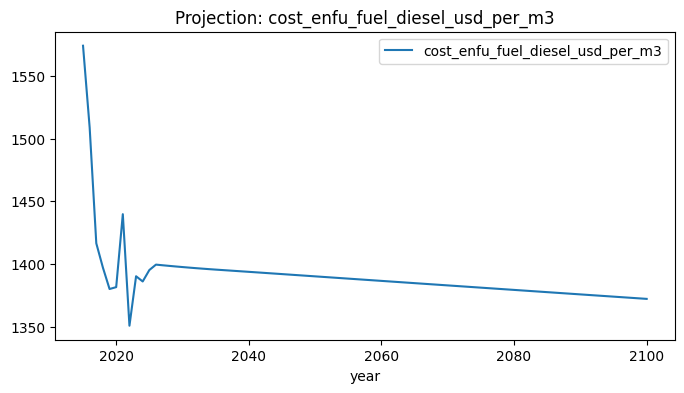

In [12]:
# Diesel price projection
df_diesel = project_fuel_price(
	df_fuels,
	growth_rates,
	modvar_vol_fuel_price.fields[2],  # diesel field
	time_periods,
	cdn,
	modvar_vol_fuel_price
)

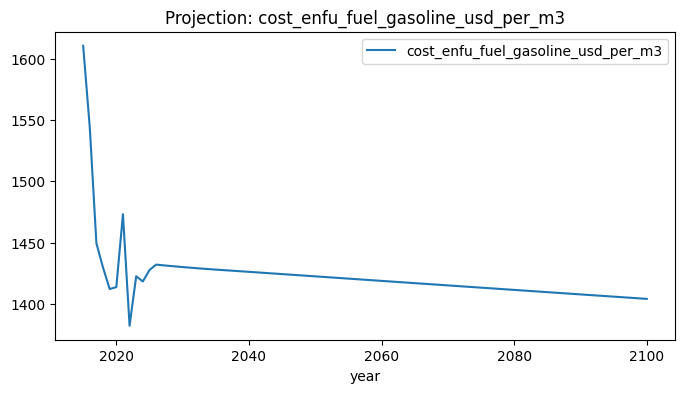

In [13]:
# Gasoline price projection
df_gasoline = project_fuel_price(
	df_fuels,
	growth_rates,
	modvar_vol_fuel_price.fields[4],  # gasoline field
	time_periods,
	cdn,
	modvar_vol_fuel_price
)


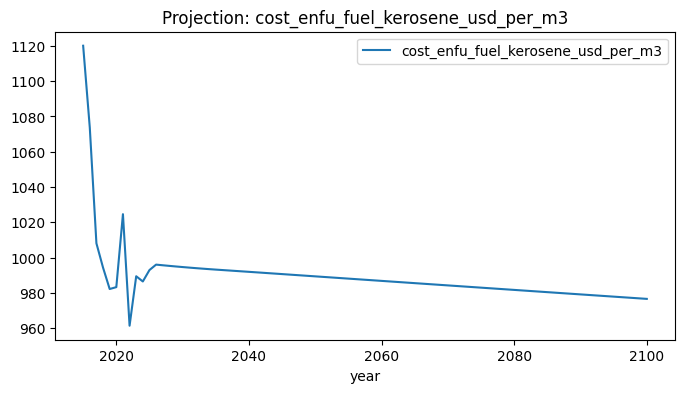

In [14]:
# Kerosene price projection
df_kerosene = project_fuel_price(
	df_fuels,
	growth_rates,
	modvar_vol_fuel_price.fields[5],  # kerosene field
	time_periods,
	cdn,
	modvar_vol_fuel_price
)

# Volumetric Fuel Price
Fuel price for fuels using units of volume (e.g., oil)

cost_enfu_$CAT-FUEL$_$UNIT-MONETARY$_per_$UNIT-VOLUME$ ($UNIT-MONETARY$ = usd, $UNIT-VOLUME$ = m3)

fuel_biofuels``|``fuel_crude``|``fuel_diesel``|``fuel_gasoline``|``fuel_furnace_gas``|``fuel_kerosene``|``fuel_oil


In [15]:
modvar_vol_fuel_price

ModelVariable: Volumetric Fuel Price
Fields:
	cost_enfu_fuel_biofuels_usd_per_m3
	cost_enfu_fuel_crude_usd_per_m3
	cost_enfu_fuel_diesel_usd_per_m3
	cost_enfu_fuel_furnace_gas_usd_per_m3
	cost_enfu_fuel_gasoline_usd_per_m3
	cost_enfu_fuel_kerosene_usd_per_m3
	cost_enfu_fuel_oil_usd_per_m3

In [16]:
global_data_path = path_git.joinpath('global_baseline_data/Energy/')

In [17]:
africa_region = [ 'UGA', 'KEN', 'TZA', 'RWA', 'COD', 'SSD', 'BDI', 'ETH', 'SOM', 'ERI']

In [18]:
# Volumetric fuel types
fuel_types = [
    "fuel_biofuels",
    "fuel_crude",
    "fuel_furnace_gas",    
    "fuel_oil"
]

dfs = []

for fuel in fuel_types:
    
    file_path = global_data_path.joinpath(
        f"cost_enfu_{fuel}_usd_per_m3/input_to_sisepuede/historical/cost_enfu_{fuel}_usd_per_m3.csv"
    )

    df_fuel = pd.read_csv(file_path)
    df_fuel = df_fuel.rename(columns={"Year": "year"})
    
    # Average for Africa region (if country column exists)
    if "Country" in df_fuel.columns:
        df_fuel = df_fuel[df_fuel["Country"].isin(africa_region)]
    df_fuel_avg = (
        df_fuel
        .groupby("year", as_index=False)
        [f"cost_enfu_{fuel}_usd_per_m3"]
        .mean()
    )
    dfs.append(df_fuel_avg)

# Merge all on 'Year'
volumetric_fuel_price = reduce(lambda left, right: pd.merge(left, right, on="year", how="outer"), dfs)
volumetric_fuel_price.head(20)

,year,cost_enfu_fuel_biofuels_usd_per_m3,cost_enfu_fuel_crude_usd_per_m3,cost_enfu_fuel_furnace_gas_usd_per_m3,cost_enfu_fuel_oil_usd_per_m3
0,2015,521.090317,381.062407,13725.64626,541.936245
1,2016,521.090317,381.062407,13725.64626,541.936245
2,2017,521.090317,381.062407,13725.64626,541.936245
3,2018,521.090317,381.062407,13725.64626,541.936245
4,2019,521.090317,381.062407,13725.64626,541.936245
5,2020,521.090317,381.062407,13725.64626,541.936245


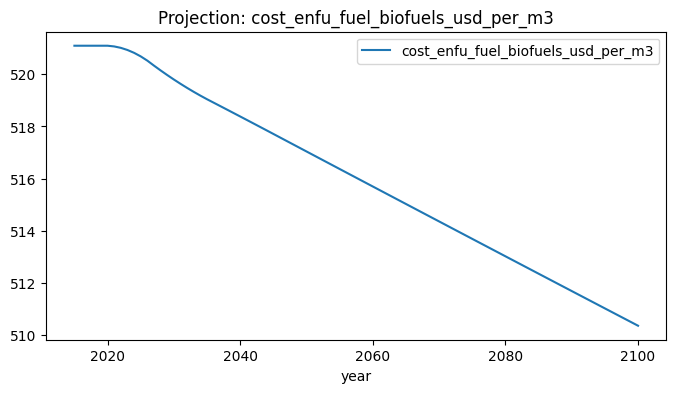

In [19]:
# biofuels price projection
df_biofuels = project_fuel_price(
	volumetric_fuel_price,
	growth_rates,
	modvar_vol_fuel_price.fields[0],  # biofuels field
	time_periods,
	cdn,
	modvar_vol_fuel_price
)

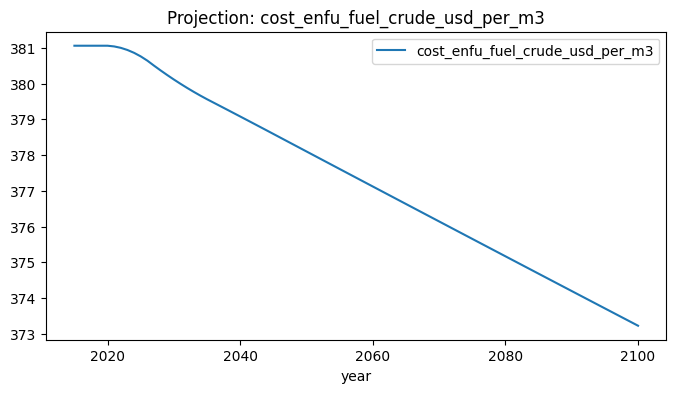

In [20]:
# crude oil price projection
df_crude = project_fuel_price(
	volumetric_fuel_price,
	growth_rates,
	modvar_vol_fuel_price.fields[1],  # crude oil field
	time_periods,
	cdn,
	modvar_vol_fuel_price
)

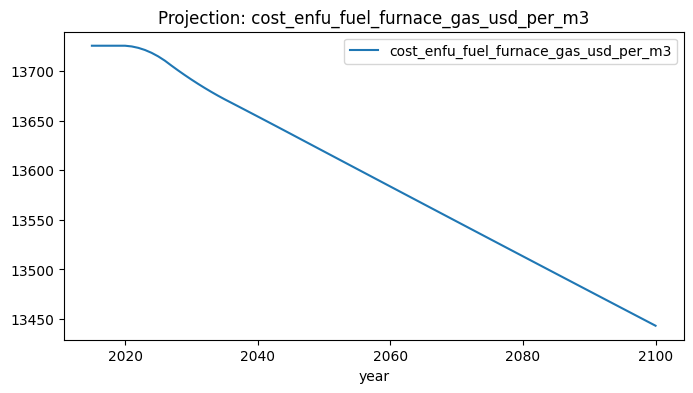

In [21]:
# furnace_gas price projection
df_furnace_gas= project_fuel_price(
	volumetric_fuel_price,
	growth_rates,
	modvar_vol_fuel_price.fields[3],  # furnace gas field
	time_periods,
	cdn,
	modvar_vol_fuel_price
)

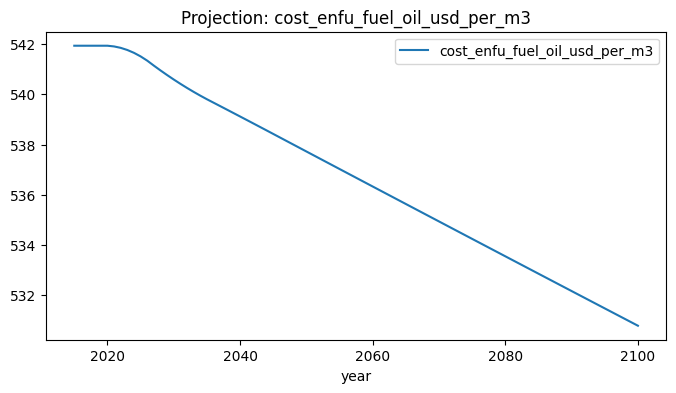

In [22]:
# Oil price projection
df_oil = project_fuel_price(
	volumetric_fuel_price,
	growth_rates,
	modvar_vol_fuel_price.fields[6],  # Oil
	time_periods,
	cdn,
	modvar_vol_fuel_price
)

In [23]:
volumetric_fuel_price = df_biofuels.merge(
    df_crude, on="year"
).merge(
    df_diesel, on="year"
).merge(
    df_furnace_gas, on="year"
).merge(
    df_gasoline, on="year"
).merge(
    df_kerosene, on="year"
).merge(
    df_oil, on="year"
)


volumetric_fuel_price

,year,cost_enfu_fuel_biofuels_usd_per_m3,cost_enfu_fuel_crude_usd_per_m3,cost_enfu_fuel_diesel_usd_per_m3,cost_enfu_fuel_furnace_gas_usd_per_m3,cost_enfu_fuel_gasoline_usd_per_m3,cost_enfu_fuel_kerosene_usd_per_m3,cost_enfu_fuel_oil_usd_per_m3
0,2015,521.090317,381.062407,1573.981481,13725.646260,1610.586420,1120.123457,541.936245
1,2016,521.090317,381.062407,1508.786982,13725.646260,1543.875740,1073.727811,541.936245
2,2017,521.090317,381.062407,1416.583333,13725.646260,1449.527778,1008.111111,541.936245
3,2018,521.090317,381.062407,1397.178082,13725.646260,1429.671233,994.301370,541.936245
4,2019,521.090317,381.062407,1380.162382,13725.646260,1412.259811,982.192152,541.936245
...,...,...,...,...,...,...,...,...
81,2096,510.899693,373.610218,1373.728607,13457.222747,1405.676411,977.613558,531.337951
82,2097,510.766992,373.513176,1373.371795,13453.727364,1405.311300,977.359632,531.199941
83,2098,510.634326,373.416160,1373.015075,13450.232890,1404.946284,977.105773,531.061967
84,2099,510.501693,373.319168,1372.658447,13446.739323,1404.581363,976.851979,530.924029


In [24]:
volumetric_fuel_price.to_csv(output_data.joinpath("VOLUMETRIC_FUEL_PRICE.csv"), index=False)

# Gravimetric Fuel Price
Fuel price for fuels using units of mass (e.g., nuclear)

cost_enfu_$CAT-FUEL$_$UNIT-MONETARY$_per_$UNIT-MASS$ ($UNIT-MONETARY$ = usd, $UNIT-MASS$ = tonne)

fuel_ammonia``|``fuel_biomass``|``fuel_coal``|``fuel_coke``|``fuel_nuclear

In [25]:
modvar_gravimetric_fuel_price = matt.get_variable("Gravimetric Fuel Price",)
modvar_gravimetric_fuel_price

ModelVariable: Gravimetric Fuel Price
Fields:
	cost_enfu_fuel_ammonia_usd_per_tonne
	cost_enfu_fuel_biomass_usd_per_tonne
	cost_enfu_fuel_coal_usd_per_tonne
	cost_enfu_fuel_coke_usd_per_tonne
	cost_enfu_fuel_nuclear_usd_per_tonne

In [26]:
# Gravimetric fuel types
fuel_types = [
    #"fuel_ammonia",
    "fuel_biomass",
    "fuel_coal",
    "fuel_coke",
    "fuel_nuclear"
]

dfs = []

for fuel in fuel_types:
    file_path = global_data_path.joinpath(
        f"cost_enfu_{fuel}_usd_per_tonne/input_to_sisepuede/historical/cost_enfu_{fuel}_usd_per_tonne.csv"
    )
    df_fuel = pd.read_csv(file_path)
    df_fuel = df_fuel.rename(columns={"Year": "year"})
    
    # Average for Africa region (if country column exists)
    if "Country" in df_fuel.columns:
        df_fuel = df_fuel[df_fuel["Country"].isin(africa_region)]
    df_fuel_avg = (
        df_fuel
        .groupby("year", as_index=False)
        [f"cost_enfu_{fuel}_usd_per_tonne"]
        .mean()
    )
    dfs.append(df_fuel_avg)

# Merge all on 'Year'
gravimetric_fuel_price = reduce(lambda left, right: pd.merge(left, right, on="year", how="outer"), dfs)
gravimetric_fuel_price

,year,cost_enfu_fuel_biomass_usd_per_tonne,cost_enfu_fuel_coal_usd_per_tonne,cost_enfu_fuel_coke_usd_per_tonne,cost_enfu_fuel_nuclear_usd_per_tonne
0,2000,NaN,NaN,NaN,1663000.0
1,2001,NaN,NaN,NaN,1663000.0
2,2002,NaN,NaN,NaN,1663000.0
3,2003,NaN,NaN,NaN,1663000.0
4,2004,NaN,NaN,NaN,1663000.0
5,2005,NaN,NaN,NaN,1663000.0
6,2006,NaN,NaN,NaN,1663000.0
7,2007,NaN,NaN,NaN,1663000.0
8,2008,NaN,NaN,NaN,1663000.0
9,2009,NaN,NaN,NaN,1663000.0


In [27]:
# Gravimetric fuel price growth rates
growth_rates = {
    "cost_enfu_fuel_ammonia_usd_per_tonne": [
        (2023, 2030, -1.2),   # Slight decrease due to efficiency gains and green hydrogen deployment
        (2030, 2040, -2.0),
        (2040, 2050, -3.0),
    ],
    "cost_enfu_fuel_biomass_usd_per_tonne": [
        (2023, 2030, 0.5),   # Slight increase due to land pressure and logistics in Africa
        (2030, 2040, 0.8),
        (2040, 2050, 1.0),
    ],
    "cost_enfu_fuel_coal_usd_per_tonne": [
        (2023, 2030, 1.0),   # Stable to slightly rising due to residual demand and regulatory costs
        (2030, 2040, 0.5),
        (2040, 2050, 0.0),
    ],
    "cost_enfu_fuel_coke_usd_per_tonne": [
        (2023, 2030, 0.5),   # Conservative estimate; similar to coal due to lack of specific data
        (2030, 2040, 0.5),
        (2040, 2050, 0.5),
    ],
    "cost_enfu_fuel_nuclear_usd_per_tonne": [
        (2023, 2030, -0.8),   # Slight decline due to technology learning and new capacity (e.g., Uganda)
        (2030, 2040, -1.5),
        (2040, 2050, -2.0),
    ],
}


In [28]:
# Ammonia price projection
df_ammonia = pd.DataFrame({
    "year": range(2015, 2023),
    "cost_enfu_fuel_ammonia_usd_per_tonne": [477] * 8
})

df_ammonia

,year,cost_enfu_fuel_ammonia_usd_per_tonne
0,2015,477
1,2016,477
2,2017,477
3,2018,477
4,2019,477
5,2020,477
6,2021,477
7,2022,477


In [29]:
gravimetric_fuel_price = gravimetric_fuel_price.merge(
    df_ammonia, on="year")

gravimetric_fuel_price

,year,cost_enfu_fuel_biomass_usd_per_tonne,cost_enfu_fuel_coal_usd_per_tonne,cost_enfu_fuel_coke_usd_per_tonne,cost_enfu_fuel_nuclear_usd_per_tonne,cost_enfu_fuel_ammonia_usd_per_tonne
0,2015,209.78,113.746982,191.939828,1663000.0,477
1,2016,209.78,113.746982,191.939828,1663000.0,477
2,2017,209.78,113.746982,191.939828,1663000.0,477
3,2018,209.78,113.746982,191.939828,1663000.0,477
4,2019,209.78,113.746982,191.939828,1663000.0,477
5,2020,209.78,113.746982,191.939828,1663000.0,477
6,2021,NaN,NaN,NaN,1663000.0,477
7,2022,NaN,NaN,NaN,1663000.0,477


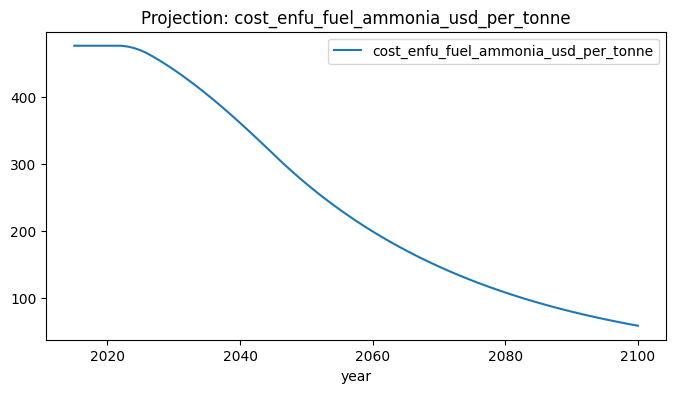

In [30]:
# Ammonia price projection

# Filter for ammonia growth rates only
ammonia_growth_rates = growth_rates["cost_enfu_fuel_ammonia_usd_per_tonne"]

df_ammonia = project_fuel_price(
	gravimetric_fuel_price,
	ammonia_growth_rates,
	modvar_gravimetric_fuel_price.fields[0],  # Ammonia
	time_periods,
	cdn,
	modvar_gravimetric_fuel_price
)

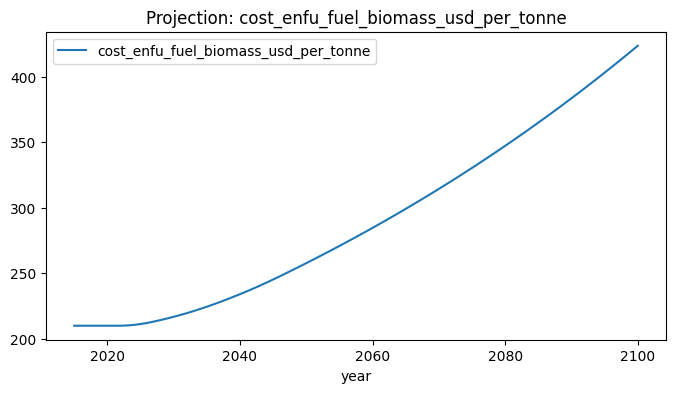

In [31]:
# biomass price projection

# Filter for biomass growth rates only
biomass_growth_rates = growth_rates["cost_enfu_fuel_biomass_usd_per_tonne"]

df_biomass = project_fuel_price(
	gravimetric_fuel_price,
	biomass_growth_rates,
	modvar_gravimetric_fuel_price.fields[1],  # Biomass
	time_periods,
	cdn,
	modvar_gravimetric_fuel_price
)

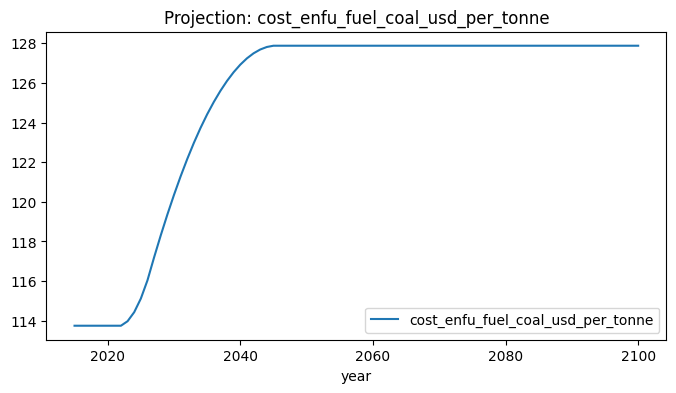

In [32]:
# coal price projection

# Filter for coal growth rates only
coal_growth_rates = growth_rates["cost_enfu_fuel_coal_usd_per_tonne"]

df_coal = project_fuel_price(
	gravimetric_fuel_price,
	coal_growth_rates,
	modvar_gravimetric_fuel_price.fields[2],  # Coal
	time_periods,
	cdn,
	modvar_gravimetric_fuel_price
)

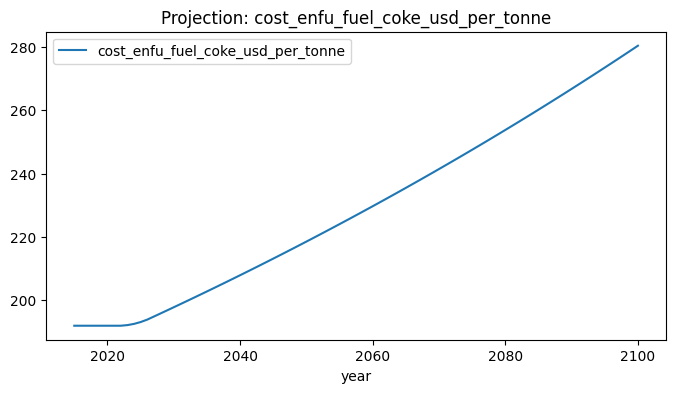

In [33]:
# coke price projection

# Filter for coke growth rates only
coke_growth_rates = growth_rates["cost_enfu_fuel_coke_usd_per_tonne"]

df_coke = project_fuel_price(
	gravimetric_fuel_price,
	coke_growth_rates,
	modvar_gravimetric_fuel_price.fields[3],  # Coke
	time_periods,
	cdn,
	modvar_gravimetric_fuel_price
)

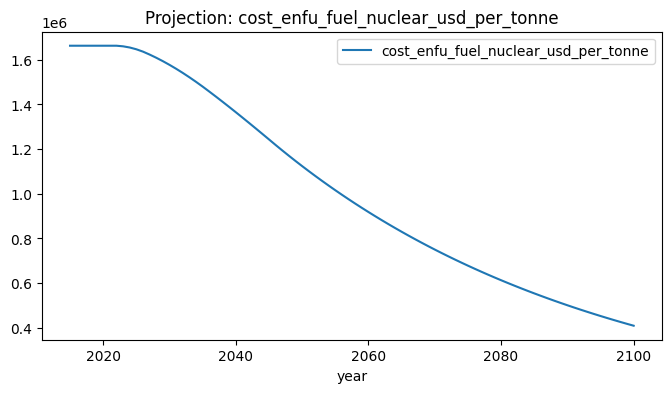

In [34]:
# nuclear price projection

# Filter for nuclear growth rates only
nuclear_growth_rates = growth_rates["cost_enfu_fuel_nuclear_usd_per_tonne"]

df_nuclear = project_fuel_price(
	gravimetric_fuel_price,
	nuclear_growth_rates,
	modvar_gravimetric_fuel_price.fields[4],  # Nuclear
	time_periods,
	cdn,
	modvar_gravimetric_fuel_price
)

In [35]:
gravimetric_fuel_price = df_ammonia.merge(
    df_biomass, on="year"
).merge(
    df_coal, on="year"
).merge(
    df_coke, on="year"
).merge(
    df_nuclear, on="year"
)

gravimetric_fuel_price

,year,cost_enfu_fuel_ammonia_usd_per_tonne,cost_enfu_fuel_biomass_usd_per_tonne,cost_enfu_fuel_coal_usd_per_tonne,cost_enfu_fuel_coke_usd_per_tonne,cost_enfu_fuel_nuclear_usd_per_tonne
0,2015,477.000000,209.780000,113.746982,191.939828,1.663000e+06
1,2016,477.000000,209.780000,113.746982,191.939828,1.663000e+06
2,2017,477.000000,209.780000,113.746982,191.939828,1.663000e+06
3,2018,477.000000,209.780000,113.746982,191.939828,1.663000e+06
4,2019,477.000000,209.780000,113.746982,191.939828,1.663000e+06
...,...,...,...,...,...,...
81,2096,66.739083,407.048727,127.879557,274.869067,4.438150e+05
82,2097,64.736911,411.119214,127.879557,276.243412,4.349387e+05
83,2098,62.794803,415.230406,127.879557,277.624629,4.262399e+05
84,2099,60.910959,419.382710,127.879557,279.012752,4.177151e+05


In [36]:
gravimetric_fuel_price.to_csv(output_data.joinpath("GRAVIMETRIC_FUEL_PRICE.csv"), index=False)

# Thermal Fuel Price
Fuel price for fuels using units of thermal energy (e.g., natural gas)

cost_enfu_$CAT-FUEL$_$UNIT-MONETARY$_per_$UNIT-ENERGY$ ($UNIT-MONETARY$ = usd, $UNIT-ENERGY$ = mmbtu)

fuel_biogas``|``fuel_electricity``|``fuel_hydrocarbon_gas_liquids``|``fuel_hydrogen``|``fuel_natural_gas``|``fuel_waste


In [37]:
modvar_thermal_fuel_price = matt.get_variable("Thermal Fuel Price",)
modvar_thermal_fuel_price

ModelVariable: Thermal Fuel Price
Fields:
	cost_enfu_fuel_biogas_usd_per_mmbtu
	cost_enfu_fuel_electricity_usd_per_mmbtu
	cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu
	cost_enfu_fuel_hydrogen_usd_per_mmbtu
	cost_enfu_fuel_natural_gas_usd_per_mmbtu
	cost_enfu_fuel_waste_usd_per_mmbtu

In [38]:
# Thermal fuel types
fuel_types = [
    "fuel_biogas",
    "fuel_electricity",
    "fuel_hydrocarbon_gas_liquids",
    "fuel_hydrogen",
    "fuel_natural_gas",
    "fuel_waste"
]

dfs = []

for fuel in fuel_types:
    file_path = global_data_path.joinpath(
        f"cost_enfu_{fuel}_usd_per_mmbtu/input_to_sisepuede/historical/cost_enfu_{fuel}_usd_per_mmbtu.csv"
    )
    df_fuel = pd.read_csv(file_path)
    df_fuel = df_fuel.rename(columns={"Year": "year"})

    # Average for Africa region (if country column exists)
    if "Country" in df_fuel.columns:
        df_fuel = df_fuel[df_fuel["Country"].isin(africa_region)]
    df_fuel_avg = (
        df_fuel
        .groupby("year", as_index=False)
        [f"cost_enfu_{fuel}_usd_per_mmbtu"]
        .mean()
    )
    dfs.append(df_fuel_avg)

# Merge all on 'year'
thermal_fuel_price = reduce(lambda left, right: pd.merge(left, right, on="year", how="outer"), dfs)
thermal_fuel_price

,year,cost_enfu_fuel_biogas_usd_per_mmbtu,cost_enfu_fuel_electricity_usd_per_mmbtu,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu,cost_enfu_fuel_hydrogen_usd_per_mmbtu,cost_enfu_fuel_natural_gas_usd_per_mmbtu,cost_enfu_fuel_waste_usd_per_mmbtu
0,2015,22.0,60.609955,186.70827,120.882889,8.251805,9380.0
1,2016,22.0,60.609955,186.70827,120.882889,8.251805,9380.0
2,2017,22.0,60.609955,186.70827,120.882889,8.251805,9380.0
3,2018,22.0,60.609955,186.70827,120.882889,8.251805,9380.0
4,2019,22.0,60.609955,186.70827,120.882889,8.251805,9380.0
5,2020,22.0,60.609955,186.70827,120.882889,8.251805,9380.0


In [39]:
growth_rates = {
    "cost_enfu_fuel_biogas_usd_per_mmbtu": [
        (2023, 2030, -0.5),   # Slight decrease due to technology improvements and landfill gas recovery
        (2030, 2040, -1.0),
        (2040, 2050, -1.5),
    ],
    "cost_enfu_fuel_electricity_usd_per_mmbtu": [
        (2023, 2030, -1.0),   # Decline due to renewables penetration and grid efficiency
        (2030, 2040, -1.2),
        (2040, 2050, -1.5),
    ],
    "cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu": [
        (2023, 2030, 0.3),   # Slight increase due to upstream costs and limited demand growth
        (2030, 2040, 0.5),
        (2040, 2050, 0.7),
    ],
    "cost_enfu_fuel_hydrogen_usd_per_mmbtu": [
        (2023, 2030, -3.0),   # Sharp decline due to scaling of green hydrogen (IEA projections)
        (2030, 2040, -4.0),
        (2040, 2050, -4.5),
    ],
    "cost_enfu_fuel_natural_gas_usd_per_mmbtu": [
        (2023, 2030, 1.0),   # Moderate increase from volatility and infrastructure costs
        (2030, 2040, 0.8),
        (2040, 2050, 0.5),
    ],
    "cost_enfu_fuel_waste_usd_per_mmbtu": [
        (2023, 2030, -0.8),   # Slight decline due to more waste-to-energy projects and carbon pricing
        (2030, 2040, -1.0),
        (2040, 2050, -1.0),
    ],
}


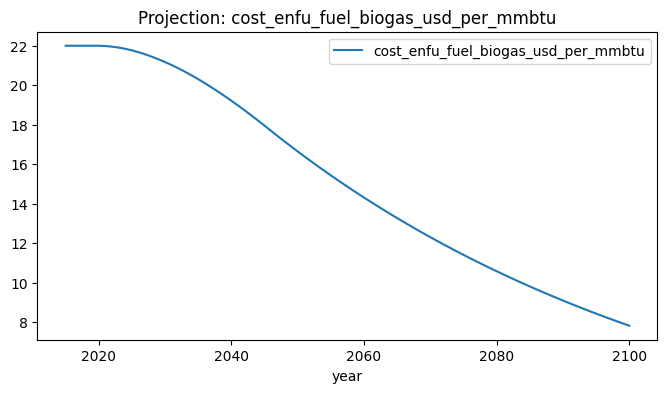

In [40]:
# biogas price projection

# Filter for biogas growth rates only
biogas_growth_rates = growth_rates["cost_enfu_fuel_biogas_usd_per_mmbtu"]

df_biogas_mmbtu = project_fuel_price(
	thermal_fuel_price,
	biogas_growth_rates,
	modvar_thermal_fuel_price.fields[0],  # Biogas
	time_periods,
	cdn,
	modvar_thermal_fuel_price
)

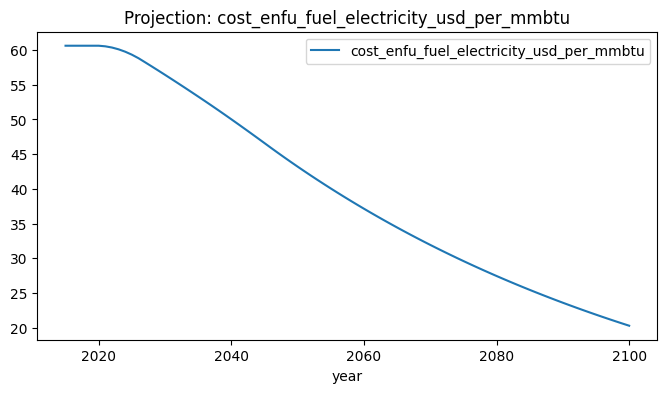

In [41]:
# electricity price projection

# Filter for electricity growth rates only
electricity_growth_rates = growth_rates["cost_enfu_fuel_electricity_usd_per_mmbtu"]

df_electricity_mmbtu = project_fuel_price(
	thermal_fuel_price,
	electricity_growth_rates,
	modvar_thermal_fuel_price.fields[1],  # Electricity
	time_periods,
	cdn,
	modvar_thermal_fuel_price
)

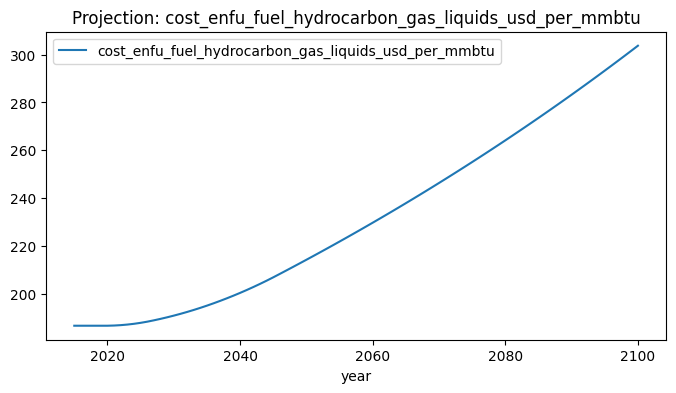

In [42]:
# hydrocarbon_gas_liquids price projection

# Filter for hydrocarbon_gas_liquids growth rates only
hydrocarbon_gas_liquids_growth_rates = growth_rates["cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu"]

df_hydrocarbon_gas_liquids_mmbtu = project_fuel_price(
	thermal_fuel_price,
	hydrocarbon_gas_liquids_growth_rates,
	modvar_thermal_fuel_price.fields[2],  # Hydrocarbon Gas Liquids
	time_periods,
	cdn,
	modvar_thermal_fuel_price
)

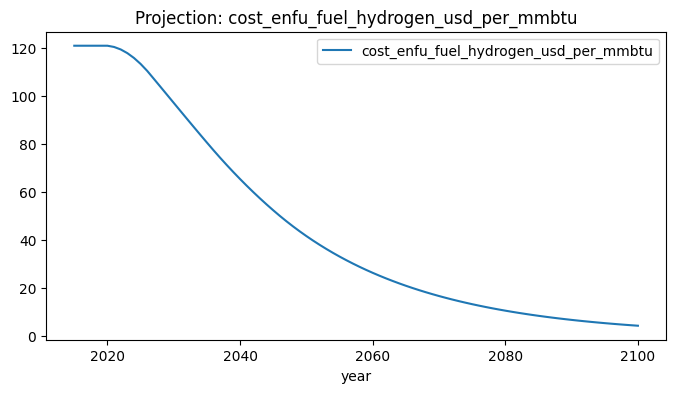

In [43]:
# hydrogen price projection

# Filter for hydrogen growth rates only
hydrogen_growth_rates = growth_rates["cost_enfu_fuel_hydrogen_usd_per_mmbtu"]

df_hydrogen_mmbtu = project_fuel_price(
	thermal_fuel_price,
	hydrogen_growth_rates,
	modvar_thermal_fuel_price.fields[3],  # Hydrogen
	time_periods,
	cdn,
	modvar_thermal_fuel_price
)

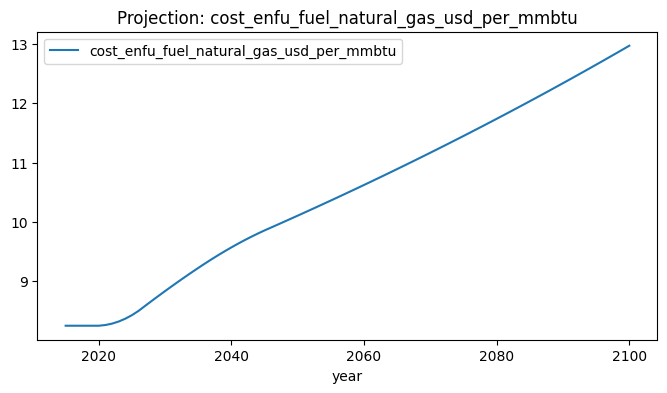

In [44]:
# natural_gas price projection

# Filter for natural_gas growth rates only
natural_gas_growth_rates = growth_rates["cost_enfu_fuel_natural_gas_usd_per_mmbtu"]

df_natural_gas_mmbtu = project_fuel_price(
	thermal_fuel_price,
	natural_gas_growth_rates,
	modvar_thermal_fuel_price.fields[4],  # Natural Gas
	time_periods,
	cdn,
	modvar_thermal_fuel_price
)

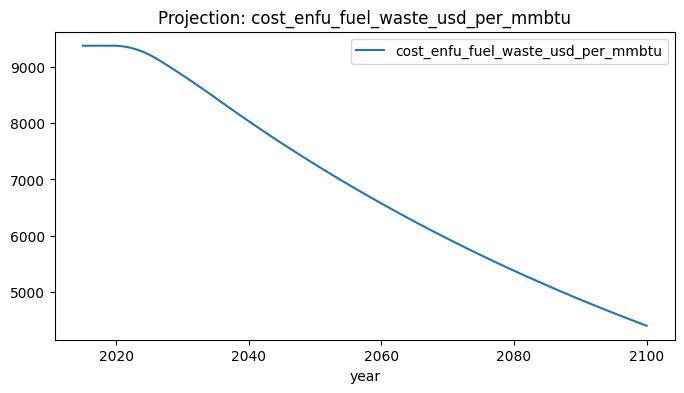

In [45]:
# waste price projection

# Filter for waste growth rates only
waste_growth_rates = growth_rates["cost_enfu_fuel_waste_usd_per_mmbtu"]

df_waste_mmbtu = project_fuel_price(
	thermal_fuel_price,
	waste_growth_rates,
	modvar_thermal_fuel_price.fields[5],  # Waste
	time_periods,
	cdn,
	modvar_thermal_fuel_price
)

In [46]:
modvar_thermal_fuel_price

ModelVariable: Thermal Fuel Price
Fields:
	cost_enfu_fuel_biogas_usd_per_mmbtu
	cost_enfu_fuel_electricity_usd_per_mmbtu
	cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu
	cost_enfu_fuel_hydrogen_usd_per_mmbtu
	cost_enfu_fuel_natural_gas_usd_per_mmbtu
	cost_enfu_fuel_waste_usd_per_mmbtu

In [47]:
thermal_fuel_price = df_biogas_mmbtu.merge(
    df_electricity_mmbtu, on="year"
).merge(
    df_hydrocarbon_gas_liquids_mmbtu , on="year"
).merge(
    df_hydrogen_mmbtu, on="year"
).merge(
    df_natural_gas_mmbtu, on="year"
).merge(
    df_waste_mmbtu, on="year"
)

thermal_fuel_price

,year,cost_enfu_fuel_biogas_usd_per_mmbtu,cost_enfu_fuel_electricity_usd_per_mmbtu,cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_mmbtu,cost_enfu_fuel_hydrogen_usd_per_mmbtu,cost_enfu_fuel_natural_gas_usd_per_mmbtu,cost_enfu_fuel_waste_usd_per_mmbtu
0,2015,22.000000,60.609955,186.708270,120.882889,8.251805,9380.000000
1,2016,22.000000,60.609955,186.708270,120.882889,8.251805,9380.000000
2,2017,22.000000,60.609955,186.708270,120.882889,8.251805,9380.000000
3,2018,22.000000,60.609955,186.708270,120.882889,8.251805,9380.000000
4,2019,22.000000,60.609955,186.708270,120.882889,8.251805,9380.000000
...,...,...,...,...,...,...,...
81,2096,8.303784,21.555445,295.317471,4.995479,12.712778,4577.213661
82,2097,8.179227,21.232113,297.384693,4.770682,12.776342,4531.441525
83,2098,8.056539,20.913631,299.466386,4.556001,12.840224,4486.127109
84,2099,7.935691,20.599927,301.562650,4.350981,12.904425,4441.265838


In [48]:
thermal_fuel_price.to_csv(output_data.joinpath("THERMAL_FUEL_PRICE.csv"), index=False)